<a href="https://colab.research.google.com/github/mthsansu/MLNLP/blob/side/Code/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><strong><font color="chillipepper">Parlementarian Sentiment Analysis: Sequence Classification</font></strong></center></h1>
<h3><center><font color="green"><strong>Baseline Model</strong></font></center></h3>

<center>
April 2022, Houri & Sansu
</center>

## <font color="chillipepper">Modules and packages</font>

In [1]:
!pip install datasets

     |████████████████████████████████| 325 kB 5.4 MB/s 
     |████████████████████████████████| 212 kB 46.8 MB/s 
     |████████████████████████████████| 136 kB 25.7 MB/s 
     |████████████████████████████████| 1.1 MB 18.5 MB/s 
     |████████████████████████████████| 77 kB 4.8 MB/s 
     |████████████████████████████████| 127 kB 40.0 MB/s 
     |████████████████████████████████| 271 kB 37.6 MB/s 
     |████████████████████████████████| 144 kB 32.6 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [6]:
import torch
import numpy as np
import datasets
from datasets import load_dataset
from tqdm import tqdm
import nltk
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import pandas as pd
from collections import Counter
import torchtext
from sklearn.model_selection import train_test_split
from termcolor import colored
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

### <font color="chillipepper">**Preprocessing function**</font>

In [7]:
def clean(text): # Parameter will be a text, here a tweet
    text = re.sub("@","", text) # Removing the "@" from mention
    text = re.sub(r'http\S+', '', text) # Removing url links
    text = text.replace('\n',' ') # Removing new line
    text = text.replace('\r',' ') # Removing new line
    text = re.sub('#', '', text) # Removing hash
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) # remove emoji
    a = re.compile('<U(.*?)>') # other missing emoji_pattern
    text = a.sub(r'', text) # remove these remaining emoji
    text = re.sub(' +', ' ', text) # Remove additional spaces
    return text # The output is the cleaned text

## <font color="chillipepper">Data</font>

**Import the annotated data**

In [8]:
# Import data
git_url = "https://raw.githubusercontent.com/mthsansu/MLNLP/main/Data/"
df = pd.read_csv(git_url + 'df_baseline.csv', index_col =0)

In [9]:
df["text"] = df["text"].apply(lambda x: clean(x))

In [10]:
df = df.rename(columns={'Label': 'label'})

**Prepare the data for machine learning tasks**

In [11]:
# Randomly split the data into train, test and validation sets using numpy
train, validate, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

In [12]:
import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset

### convert to Huggingface dataset
train_dataset = Dataset(pa.Table.from_pandas(train))
test_dataset = Dataset(pa.Table.from_pandas(test))
val_dataset = Dataset(pa.Table.from_pandas(validate))

## <font color="chillipepper">Pre-trained Embeddings</font>

**First NLP tasks**

In [13]:
# Run only once: several min long
# Import fasttext vectors through torch text (it will download it only once)
from torchtext.vocab import vocab, FastText

pretrained_vectors = FastText(language='fr')

.vector_cache/wiki.fr.vec: 3.03GB [01:07, 44.5MB/s]                            
100%|██████████| 1152449/1152449 [02:47<00:00, 6864.26it/s]


In [14]:
pretrained_vocab = vocab(pretrained_vectors.stoi)
unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1
pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried 
pretrained_vocab.set_default_index(unk_index)
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([1152450, 300])

## <font color="chillipepper">Tokenization</font>

In [15]:
# Import nltk's TweetTokenizer to use it in the definition of our own tokenizer functions
from nltk.tokenize import TweetTokenizer
from tqdm.notebook import tqdm

tok = TweetTokenizer()

In [16]:
# This function will tokenize each tweet, standardize the string sizes using zero-padding, and numericalize each token to an index
def tokenize_pad_numericalize(entry, vocab_stoi, max_length=20):
  text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(entry.lower())]
  padded_text = None
  if len(text) < max_length:   padded_text = text + [ vocab_stoi['<pad>'] for i in range(len(text), max_length) ] 
  elif len(text) > max_length: padded_text = text[:max_length]
  else:                        padded_text = text
  return padded_text

# This function is a generalization of the function above, now applicable to multiple tweets at a time
def tokenize_all(entries, vocab_stoi):
  res = {}
  res['text'] = [tokenize_pad_numericalize(entry, vocab_stoi, max_length=200) for entry in entries['text']]
  return res

In [17]:
# Tokenize our three data subsets
train_dataset = train_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)
test_dataset = test_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)
val_dataset = val_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

## <font color="chillipepper">Building of the model</font>

In [18]:
# Create the Dataset class

from torch.utils.data import Dataset

class TweetDataset(Dataset):
    def __init__(self, data, args):
      # args is a dict, a nice way to share the global arguments (even accross multiple files)
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx]['text']),
          "label": np.array(self.data[idx]['label'])
      }
      return item

In [19]:
# Create DataLoader
from torch.utils.data import DataLoader
args = {'bsize': 64}
train_loader = DataLoader(TweetDataset(train_dataset, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
test_loader  = DataLoader(TweetDataset(test_dataset, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
val_loader  = DataLoader(TweetDataset(val_dataset, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [20]:
# Define the model to classify tweets

class TweetModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, pretrained_vectors=None):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TweetModel, self).__init__()
        # apply the pretrained embeddings to transform our token indices, into vectors
        self.ebd = torch.nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        self.hidden_linear_layer = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.classification_layer = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        # softmax layer to compute class probabilities
        # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax
        self.softmax = nn.Softmax(dim=1)

        # define the dropout strategy (here, 20% (0.2) of the vector is ignored to prevent overfitting)
        # we don't use it here but it's a good thing to keep in mind
        # self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # apply the pretrained embeddings
        x  = self.ebd(x)
        x  = x.mean(1)
        h  = torch.relu(self.hidden_linear_layer( x ))
        # h  = self.dropout(h)
        h  = self.classification_layer(h)
        logits = self.softmax(h)
        return logits

In [21]:
sizes = next(iter(train_loader))['text'].size()
batchsize = sizes[0] # We have chosen a batchsize equal to 64
inputdim  = sizes[1] # The input layer of our NN has 200 elements because when we padded the data, we set max_length=200
print(batchsize, inputdim)

64 200


In [22]:
hiddendim = 300 # dimension of the pretrained vector
outputdim = 3 # because there is 3 classes, i.e. 3 labels
# we instanciate the model
tweet_model = TweetModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)

In [23]:
# we can look at the model 
tweet_model

TweetModel(
  (ebd): Embedding(1152449, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

**We'll need a GPU**

In [24]:
if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  device = 'cpu'
  print('DEVICE = ', colored('CPU', "blue"))
tweet_model.to(device)

DEVICE =  Tesla K80


TweetModel(
  (ebd): Embedding(1152449, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

**Train the model**

In [25]:
# Training loop

def train(model, optimizer, ep, args):
  # set the model into a training mode : the model's weights and parameters WILL BE updated!
  model.train()
  # initialize empty lists for losses and accuracies
  loss_it, acc_it = list(), list()

  # start the loop over all the training batches. This means one full epoch.
  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=train_loader.__len__()):
    
    batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

    # put parameters of the model and the optimizer to zero before doing another iteration. this prevents the gradient accumulation through batches
    optimizer.zero_grad()

    # apply the model on the batch
    logits = model(batch['text'])

    # # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
    b_counter = Counter(batch['label'].detach().cpu().tolist())
    b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(args['num_class'])) ] )
    b_weights = b_weights.to(device)

    # we choose the CrossEntropyLoss, suitable for multiclass classification
    # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    loss_function = nn.CrossEntropyLoss(weight=b_weights)
    # loss_function = nn.CrossEntropyLoss()
    loss = loss_function(logits, batch['label'])

    # compute backpropagation
    loss.backward()

    # indicate to the optimizer we've done a step
    optimizer.step()

    # append the value of the loss for the current iteration (it). .item() retrieve the nuclear value as a int/long
    loss_it.append(loss.item())

    # get the predicted tags using the maximum probability from the softmax
    _, tag_seq  = torch.max(logits, 1)
    
    # Those 3 lines compute the accuracy and then append it the same way as the loss above
    correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
    acc = correct / batch['label'].flatten().size(0)
    acc_it.append(acc.item())

  # simple averages of losses and accuracies for this epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))


In [26]:
def inference(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """

  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  preds, trues = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():

      # put the batch to the correct device
      batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

      # apply the model
      logits = model(batch['text'])

      # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
      # b_counter = Counter(batch['label'].detach().cpu().tolist())
      # b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(20)) ] )
      # b_weights = b_weights.to(device)

      # loss_function = nn.CrossEntropyLoss(weight=b_weights)
      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(logits, batch['label'])

      # no need to backward() and other training stuff. Directly store the loss in the list
      loss_it.append(loss.item())

      # get the predicted tags using the maximum probability from the softmax
      _, tag_seq  = torch.max(logits, 1)
      
      # compute the accuracy and store it
      correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      acc = correct / batch['label'].flatten().size(0)
      acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['label'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

In [46]:
# Start training

import torch.optim as optim

def run_epochs(model, args):

  # args['device'] =device
  if args['cuda'] != -1:
      model.cuda(args['cuda'])
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      args['device'] = device
      print("device set to %s" % (device) )

  # we set the optimizer as Adam with the learning rate (lr) set in the arguments
  # you can look at the different optimizer available here: https://pytorch.org/docs/stable/optim.html
  # optimizer = optim.Adam(model.parameters(), lr = args['lr'])
  optimizer = optim.Adam(model.parameters(), lr=5e-5)

  # define an empty list to store validation losses for each epoch
  val_ep_losses = list()
  # iterate over the number of max epochs set in the arguments
  for ep in range(args['max_eps']):
    # train the model using our defined function
    train(model, optimizer, ep, args)
    # apply the model for inference using our defined function
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val_loader, model)
    # append the validation losses (good losses should normally go down)
    val_ep_losses.append(val_loss_it_avg)

  # return the list of epoch validation losses in order to use it later to create a plot
  return val_ep_losses
    

In [47]:
def predict(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """

  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  #loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  #preds, trues = list(), list()
  ids, preds = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():

      # put the batch to the correct device
      batch = {'text': batch['text'].to(device), 'id': batch['id'].to(device)}
      #batch = {'text': batch['text'].to(device)}

      # apply the model
      logits = model(batch['text'])

      # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
      # b_counter = Counter(batch['label'].detach().cpu().tolist())
      # b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(20)) ] )
      # b_weights = b_weights.to(device)

      # loss_function = nn.CrossEntropyLoss(weight=b_weights)
      #loss_function = nn.CrossEntropyLoss()
      #loss = loss_function(logits, batch['label'])

      # no need to backward() and other training stuff. Directly store the loss in the list
      #loss_it.append(loss.item())

      # get the predicted tags using the maximum probability from the softmax
      _, tag_seq  = torch.max(logits, 1)
      
      # compute the accuracy and store it
      #correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      #acc = correct / batch['label'].flatten().size(0)
      #acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      ids.extend(batch['id'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  #loss_it_avg = sum(loss_it)/len(loss_it)
  #acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  #print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  #return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it
  return ids, preds

In [48]:
# here you can specify if you want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If you only have one GPU, put 0.
args.update({'max_eps': 80, 'lr': 0.001, 'device': 'gpu', 'cuda': 0, 'num_class': 3})
# 1e-05
print('device', device)
# Instantiate model with pre-trained glove vectors
# model = TweetModel(pretrained_embeddings, args['num_class'], args, dimension=50, freeze_embeddings = True )
tweet_model = TweetModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)
loss_list_val = run_epochs(tweet_model, args)

device cuda
device set to cuda


Epoch 0::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 0/80 : Training : (loss 1.0985438028971355) (acc 0.2673611111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0994490385055542) (acc 0.234375)


Epoch 1::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/80 : Training : (loss 1.0983794000413682) (acc 0.3090277777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0985418160756428) (acc 0.3645833333333333)


Epoch 2::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/80 : Training : (loss 1.0982574092017279) (acc 0.375)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0977464119593303) (acc 0.421875)


Epoch 3::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/80 : Training : (loss 1.0981365309821234) (acc 0.359375)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0973553657531738) (acc 0.4322916666666667)


Epoch 4::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/80 : Training : (loss 1.0980518658955891) (acc 0.3628472222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0970841646194458) (acc 0.4375)


Epoch 5::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/80 : Training : (loss 1.0979642073313396) (acc 0.3628472222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0969828367233276) (acc 0.421875)


Epoch 6::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/80 : Training : (loss 1.0978831185234919) (acc 0.3697916666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0969562927881877) (acc 0.4114583333333333)


Epoch 7::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/80 : Training : (loss 1.0976907942030165) (acc 0.3645833333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.096638520558675) (acc 0.4375)


Epoch 8::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/80 : Training : (loss 1.0976679192648993) (acc 0.3732638888888889)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0967973868052165) (acc 0.421875)


Epoch 9::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/80 : Training : (loss 1.0975610547595553) (acc 0.3697916666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.096684217453003) (acc 0.4375)


Epoch 10::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/80 : Training : (loss 1.09755453798506) (acc 0.3767361111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0965283314387004) (acc 0.4427083333333333)


Epoch 11::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/80 : Training : (loss 1.0974201096428766) (acc 0.375)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0963571468989055) (acc 0.4322916666666667)


Epoch 12::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/80 : Training : (loss 1.0972524748908148) (acc 0.3802083333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0962215264638264) (acc 0.4427083333333333)


Epoch 13::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/80 : Training : (loss 1.0969998704062567) (acc 0.3819444444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0960139830907185) (acc 0.4322916666666667)


Epoch 14::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/80 : Training : (loss 1.0969490210215251) (acc 0.3854166666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0961587031682332) (acc 0.421875)


Epoch 15::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/80 : Training : (loss 1.0967787239286635) (acc 0.3784722222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0958864291508992) (acc 0.421875)


Epoch 16::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/80 : Training : (loss 1.0966758463117812) (acc 0.3802083333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0954012870788574) (acc 0.4375)


Epoch 17::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/80 : Training : (loss 1.0964923832151625) (acc 0.390625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0955094893773396) (acc 0.4322916666666667)


Epoch 18::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/80 : Training : (loss 1.0962467061148748) (acc 0.3819444444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0952857732772827) (acc 0.453125)


Epoch 19::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/80 : Training : (loss 1.0962335003746881) (acc 0.3888888888888889)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0951526165008545) (acc 0.453125)


Epoch 20::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/80 : Training : (loss 1.0961445437537298) (acc 0.3923611111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0949800411860149) (acc 0.4583333333333333)


Epoch 21::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/80 : Training : (loss 1.096093389723036) (acc 0.390625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0948609511057537) (acc 0.4583333333333333)


Epoch 22::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/80 : Training : (loss 1.0957057740953233) (acc 0.3888888888888889)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0949755907058716) (acc 0.4427083333333333)


Epoch 23::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/80 : Training : (loss 1.0954778724246554) (acc 0.3940972222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0943457285563152) (acc 0.453125)


Epoch 24::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/80 : Training : (loss 1.0953759882185194) (acc 0.3923611111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.094671607017517) (acc 0.4322916666666667)


Epoch 25::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/80 : Training : (loss 1.0951634910371568) (acc 0.3940972222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.094259262084961) (acc 0.4322916666666667)


Epoch 26::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/80 : Training : (loss 1.0949071248372395) (acc 0.3940972222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0937941869099934) (acc 0.4322916666666667)


Epoch 27::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/80 : Training : (loss 1.094768590397305) (acc 0.390625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0940143664677937) (acc 0.4270833333333333)


Epoch 28::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/80 : Training : (loss 1.094753132926093) (acc 0.3854166666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0936335325241089) (acc 0.4322916666666667)


Epoch 29::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/80 : Training : (loss 1.0944250557157729) (acc 0.3888888888888889)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0933767954508464) (acc 0.4270833333333333)


Epoch 30::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/80 : Training : (loss 1.0940961970223322) (acc 0.3923611111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0929487546284993) (acc 0.4270833333333333)


Epoch 31::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31/80 : Training : (loss 1.0939431455400255) (acc 0.3923611111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0931288003921509) (acc 0.4114583333333333)


Epoch 32::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32/80 : Training : (loss 1.0937921206156414) (acc 0.3958333333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0934016307195027) (acc 0.4166666666666667)


Epoch 33::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33/80 : Training : (loss 1.0937059587902493) (acc 0.3854166666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.092430830001831) (acc 0.4270833333333333)


Epoch 34::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34/80 : Training : (loss 1.0934313535690308) (acc 0.3940972222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0927555958429973) (acc 0.4166666666666667)


Epoch 35::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35/80 : Training : (loss 1.092846777704027) (acc 0.3975694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.092482089996338) (acc 0.421875)


Epoch 36::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36/80 : Training : (loss 1.0928535328971014) (acc 0.3871527777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0915772914886475) (acc 0.4270833333333333)


Epoch 37::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37/80 : Training : (loss 1.0923340320587158) (acc 0.3940972222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0920518636703491) (acc 0.4166666666666667)


Epoch 38::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38/80 : Training : (loss 1.0918922556771173) (acc 0.3940972222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0915862719217937) (acc 0.421875)


Epoch 39::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39/80 : Training : (loss 1.0921996037165325) (acc 0.3888888888888889)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0912198225657146) (acc 0.4166666666666667)


Epoch 40::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/80 : Training : (loss 1.091743442747328) (acc 0.3940972222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0907012621561687) (acc 0.4270833333333333)


Epoch 41::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41/80 : Training : (loss 1.091610895262824) (acc 0.390625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0913642247517903) (acc 0.4114583333333333)


Epoch 42::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 42/80 : Training : (loss 1.0909000900056627) (acc 0.3958333333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0906819899876912) (acc 0.421875)


Epoch 43::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 43/80 : Training : (loss 1.0911073287328084) (acc 0.390625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0910682280858357) (acc 0.4114583333333333)


Epoch 44::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 44/80 : Training : (loss 1.0901126596662734) (acc 0.3975694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.089473009109497) (acc 0.4322916666666667)


Epoch 45::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 45/80 : Training : (loss 1.0901765955819025) (acc 0.3958333333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.089193304379781) (acc 0.4375)


Epoch 46::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 46/80 : Training : (loss 1.090232663684421) (acc 0.3888888888888889)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0892057021458943) (acc 0.421875)


Epoch 47::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 47/80 : Training : (loss 1.0901265276802912) (acc 0.3854166666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.089464783668518) (acc 0.421875)


Epoch 48::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 48/80 : Training : (loss 1.0892986721462674) (acc 0.3975694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.089720328648885) (acc 0.4166666666666667)


Epoch 49::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 49/80 : Training : (loss 1.088632067044576) (acc 0.4010416666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0897616942723591) (acc 0.40625)


Epoch 50::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 50/80 : Training : (loss 1.0890051656299167) (acc 0.3975694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0884113311767578) (acc 0.421875)


Epoch 51::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 51/80 : Training : (loss 1.0887899663713243) (acc 0.390625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0880319277445476) (acc 0.4166666666666667)


Epoch 52::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 52/80 : Training : (loss 1.0881781445609198) (acc 0.3923611111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.087865153948466) (acc 0.4166666666666667)


Epoch 53::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 53/80 : Training : (loss 1.0871129168404474) (acc 0.4010416666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0875910520553589) (acc 0.4166666666666667)


Epoch 54::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 54/80 : Training : (loss 1.0881446997324626) (acc 0.390625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0879398981730144) (acc 0.4114583333333333)


Epoch 55::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 55/80 : Training : (loss 1.0871574481328328) (acc 0.3958333333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0881320238113403) (acc 0.4114583333333333)


Epoch 56::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 56/80 : Training : (loss 1.0869160228305392) (acc 0.3993055555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.087967316309611) (acc 0.4166666666666667)


Epoch 57::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 57/80 : Training : (loss 1.0866008202234905) (acc 0.3993055555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0858282645543416) (acc 0.4166666666666667)


Epoch 58::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 58/80 : Training : (loss 1.0861610306633844) (acc 0.3940972222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0873677333196003) (acc 0.40625)


Epoch 59::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 59/80 : Training : (loss 1.0852310525046454) (acc 0.4027777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0853289763132732) (acc 0.421875)


Epoch 60::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 60/80 : Training : (loss 1.0856014755037096) (acc 0.3940972222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0834644238154094) (acc 0.4322916666666667)


Epoch 61::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 61/80 : Training : (loss 1.0858283307817247) (acc 0.3958333333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0857170820236206) (acc 0.40625)


Epoch 62::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 62/80 : Training : (loss 1.0848080184724596) (acc 0.4027777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0850488742192586) (acc 0.421875)


Epoch 63::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 63/80 : Training : (loss 1.0844873587290447) (acc 0.3993055555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0865744749704997) (acc 0.4114583333333333)


Epoch 64::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 64/80 : Training : (loss 1.0840267870161269) (acc 0.3975694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.084382692972819) (acc 0.4114583333333333)


Epoch 65::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 65/80 : Training : (loss 1.0838929282294378) (acc 0.390625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0846103032430012) (acc 0.4114583333333333)


Epoch 66::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 66/80 : Training : (loss 1.0833277967241075) (acc 0.4010416666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0851358970006306) (acc 0.4114583333333333)


Epoch 67::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 67/80 : Training : (loss 1.0833326710595026) (acc 0.3975694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0836978753407795) (acc 0.4114583333333333)


Epoch 68::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 68/80 : Training : (loss 1.083116888999939) (acc 0.3940972222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0842411120732625) (acc 0.40625)


Epoch 69::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 69/80 : Training : (loss 1.0812728802363079) (acc 0.4027777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0834657351175945) (acc 0.4166666666666667)


Epoch 70::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 70/80 : Training : (loss 1.082647932900323) (acc 0.3993055555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0832353830337524) (acc 0.4114583333333333)


Epoch 71::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 71/80 : Training : (loss 1.081989460521274) (acc 0.3993055555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0843754609425862) (acc 0.40625)


Epoch 72::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 72/80 : Training : (loss 1.0813624726401434) (acc 0.4010416666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.082923173904419) (acc 0.4166666666666667)


Epoch 73::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 73/80 : Training : (loss 1.0802420377731323) (acc 0.3993055555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0809344847997029) (acc 0.4166666666666667)


Epoch 74::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 74/80 : Training : (loss 1.0799784527884588) (acc 0.4010416666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0829812288284302) (acc 0.4010416666666667)


Epoch 75::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 75/80 : Training : (loss 1.0814243687523737) (acc 0.4027777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0841010411580403) (acc 0.4010416666666667)


Epoch 76::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 76/80 : Training : (loss 1.0795999103122287) (acc 0.4114583333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.081559141476949) (acc 0.4114583333333333)


Epoch 77::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 77/80 : Training : (loss 1.0805468824174669) (acc 0.3958333333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0815447568893433) (acc 0.40625)


Epoch 78::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 78/80 : Training : (loss 1.0796715683407254) (acc 0.40625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.081192135810852) (acc 0.4166666666666667)


Epoch 79::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 79/80 : Training : (loss 1.0800200435850356) (acc 0.4010416666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0821410020192463) (acc 0.40625)


Let's plot the loss function

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_loss(loss_list):
  '''
  this function creates a plot. a simple curve showing the different values at each steps.
  Here we use it to plot the loss so we named it plot_loss, but the same function with different titles could be used to plot accuracies
  or other metrics for instance.
  
  Args:
    loss_list (list of floats): list of numerical values
  '''
  plt.plot(range(len(loss_list)), loss_list)
  plt.xlabel('epochs')
  # in our model we use Softmax then NLLLoss which means Cross Entropy loss
  plt.ylabel('Cross Entropy')
  # in our training loop we used an Adam optimizer so we indicate it there
  # plt.title('lr: {}, optim_alg:{}'.format(args['lr'], 'Adam')) 
  plt.title('lr: {}, optim_alg:{}'.format(5e-5, 'Adam'))

  # let's directly show the plot when calling this function
  plt.show()

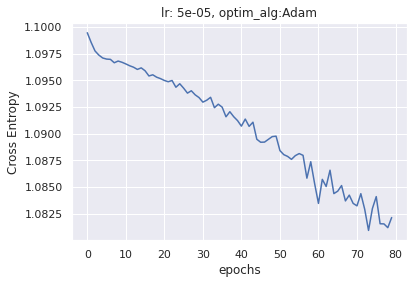

In [66]:
# let's call our function using the list of validation losses to show the plot
plot_loss(loss_list_val)

**Evaluate the model**

In [67]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, tweet_model)

test::   0%|          | 0/3 [00:00<?, ?it/s]

test : (loss 1.0734122196833293) (acc 0.4114583333333333)


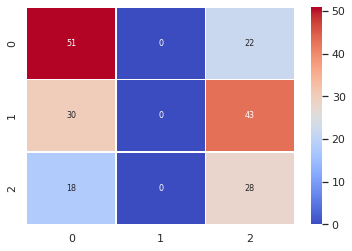

In [68]:
# Confusion matrix

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn
names = [0,1,2]
cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

In [53]:
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("validate", val_loader, tweet_model)

validate::   0%|          | 0/3 [00:00<?, ?it/s]

validate : (loss 1.0786812702814739) (acc 0.4114583333333333)


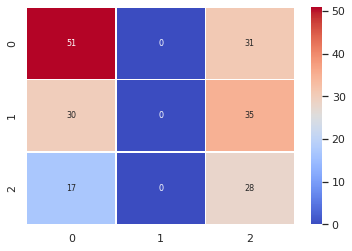

In [54]:
# Confusion matrix

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn
names = [0,1,2]
cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

## Applying the model to the study dataset

In [55]:
# Import data
git_url = "https://raw.githubusercontent.com/mthsansu/MLNLP/main/Data/"
df = pd.read_csv(git_url + 'Tweets_sample_confinement.csv', index_col =0)

In [56]:
import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset

### convert to Huggingface dataset
df_conf = Dataset(pa.Table.from_pandas(df))

In [57]:
df_conf = df_conf.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

  0%|          | 0/33 [00:00<?, ?ba/s]

In [58]:
# Create the Dataset class

from torch.utils.data import Dataset

class TweetDatasetId(Dataset):
    def __init__(self, data, args):
      # args is a dict, a nice way to share the global arguments (even accross multiple files)
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx]['text']),
          "id": np.array(self.data[idx]['id'])
      }
      return item

In [59]:
# Create the data loader

# Create DataLoader
from torch.utils.data import DataLoader
args = {'bsize': 64}
df_conf_loader = DataLoader(TweetDatasetId(df_conf, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [60]:
id_conf,pred_conf = predict("data_conf", df_conf_loader, tweet_model)

data_conf::   0%|          | 0/511 [00:00<?, ?it/s]

In [61]:
df_pred = pd.DataFrame({"id": id_conf,"pred": pred_conf})

In [62]:
df_pred

,id,pred
0,1239490964210823168,2
1,1255151447089377281,2
2,1262829593016311810,0
3,1246759603557236736,0
4,1266768516671254528,2
...,...,...
32699,1254412782948278274,0
32700,1249985059416915970,0
32701,1258400731276750850,2
32702,1254386852045479939,2


In [63]:
df_pred.pred.value_counts()

2    22369
0    10335
Name: pred, dtype: int64